# Compare Hmov vs spnoise models

## Setup

In [ ]:
run -im djd.main -- --dbname=dj_lisa --user=write

In [ ]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.gridspec as gridspec
import seaborn as sns
from scipy import stats

from djd.plot import cm2inch, adjust_spines
from djd.glms import (plot_model, plot_rf_filters, plot_train_test_psth, get_best_model, get_rf_area, get_rf_qi, 
                      get_strf_comps, get_srf_contour, rescale)

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
## Update plot parameters
# Option 1: Update general pars from modified matplotlibrc file
# plt.rcParams.update(mpl.rc_params_from_file('../../matplotlibrc', fail_on_error=False, use_default_template=True))

# Option 2: Dynamically update general pars (use if not updating from modified matplotlibrc)
plt.rcParams.update({
    'figure.dpi': 150,
    'figure.max_open_warning': 0, 
    'axes.linewidth': 0.5,
    'xtick.major.width': 0.5,
    'ytick.major.width': 0.5,
    'axes.labelsize': 'medium',
    'font.sans-serif': ['Arial'],
    'pdf.fonttype': 42, # make text editable (otherwise saved as non-text path/shape)
    'ps.fonttype': 42, # make text editable (otherwise saved as non-text path/shape)
    })


# Dynamically update plot-specific pars
plt.rcParams.update({
    'figure.dpi': 150,
    'figure.max_open_warning': 0,
    'font.size': 8,
    'axes.labelsize': 7.0,
    'axes.titlesize': 8,
    'legend.fontsize': 7,
    'xtick.labelsize': 7,
    'ytick.labelsize': 7,    
    })

In [8]:
# Make figure directory unless it already exists
fig_dir = os.path.join(os.getcwd(), 'figs')  # os.path.dirname(__file__) would give DJD path
if not os.path.exists(fig_dir):
    print(f"Making figure save directory:/n{fig_dir}")
    os.makedirs(fig_dir)

Making figure save directory: /Users/ybauer/code/hollymov_code/hmov_code/hmov_vs_spnoise_models/figs


## Plot hmov vs spnoise models for example cell

### Option 1: Define specific hmov and spnoise param keys

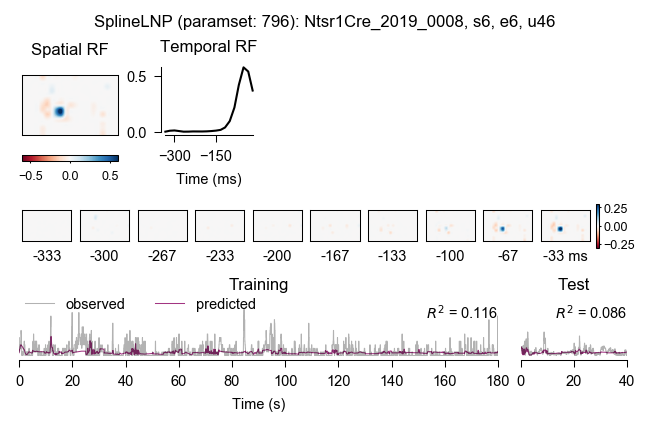

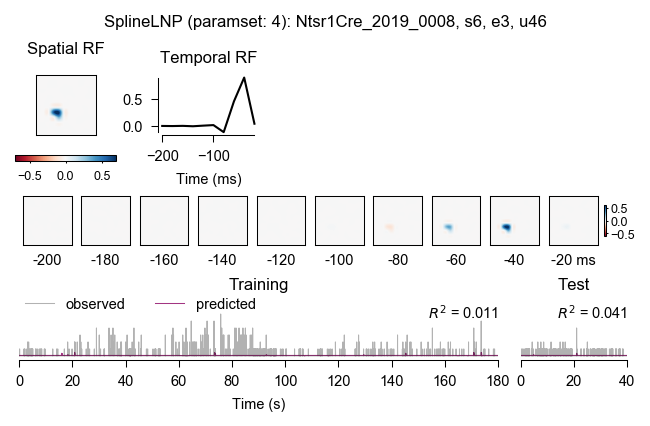

In [11]:
hmov_key = {'m': 'Ntsr1Cre_2019_0008', 's': 6, 'e': 6, 'u': 46, 'spl_paramset': 796}
sn_key = {'m': 'Ntsr1Cre_2019_0008', 's': 6, 'e': 3, 'u': 46, 'spl_paramset': 4}

fig, ax = plot_model(hmov_key, title=True)
fig, ax = plot_model(sn_key, title=True)

### Option 2: Define ukey and find best model for hmov and spnoise

hmov key: {'m': 'Ntsr1Cre_2019_0008', 's': 6, 'e': 6, 'u': 46, 'spl_paramset': 796}
  hmov RF pos (x,y): (8, 5)
  hmov RF QI: 0.812102
  hmov RF area: 138.042
spnoise key: {'m': 'Ntsr1Cre_2019_0008', 's': 6, 'e': 3, 'u': 46, 'spl_paramset': 4}
  spnoise RF pos (x,y): (4, 4)
  spnoise RF QI: 0.774406
  spnoise RF area: 99.283
Saving file to ./figs/hmov_model_Ntsr1Cre_2019_0008_s6_u46.pdf
Saving file to ./figs/sn_model_Ntsr1Cre_2019_0008_s6_u46.pdf


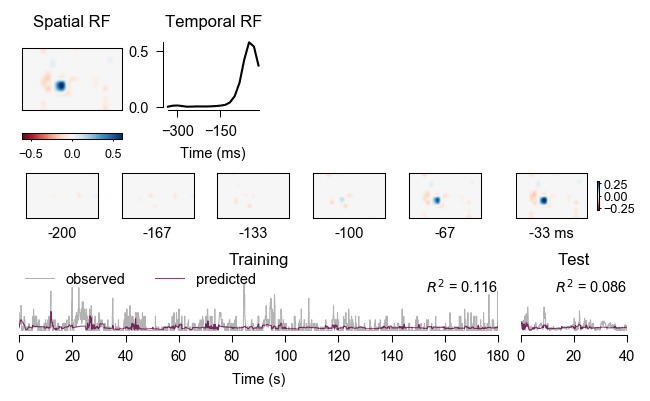

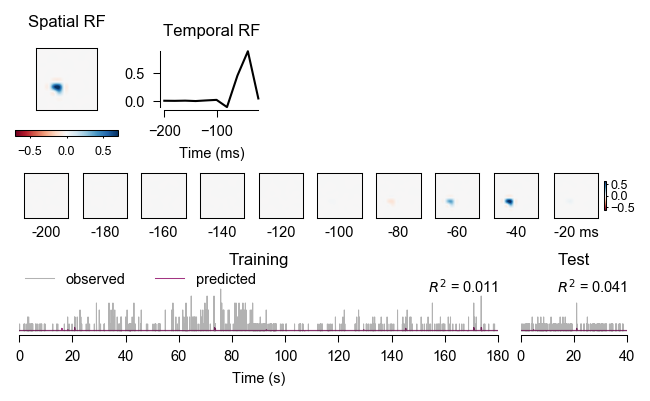

In [19]:
# Define unit key
ukey = {'m': 'Ntsr1Cre_2019_0008', 's': 6, 'u': 46}

## Plot best hmov model
# Restrict to models with stimulus-only and spatial resolution to match spnoise model
key = (SplineLNP.Eval() * SplineLNPParams() & ukey 
       & {'spl_stim': 'hmov', 'spl_spat_df': 13, #'spl_spat_scaling': 0.0495, 
          'spl_pshf': 'False', 'spl_opto': 'False', 'spl_run': 'False', 'spl_eye': 'False'}
       & 'spl_spat_scaling LIKE 0.0495'  # due to SQL float imprecision
      ).fetch(dj.key)
key = get_best_model(key, crit='spl_r_test', key_only=True, format='dict')  # picks best model
fig_hm, axs_hm = plot_model(key, strf_tlims=[-200, 0], title=False)
print(f'hmov key: {key}')

# Print some stats
rf_xpos, rf_ypos, rf_qi, rf_area = (SplineLNP.Eval() & key).fetch1('spl_rf_x_pos_pix', 'spl_rf_y_pos_pix', 'spl_rf_qi', 'spl_rf_area') 
print(f'  hmov RF pos (x,y): ({rf_xpos}, {rf_ypos})')
print(f'  hmov RF QI: {rf_qi}')
print(f'  hmov RF area: {rf_area}')


## Plot best sparse noise model
# Restrict to models with stimulus-only and spatial resolution to match hmov model
key = (SplineLNP.Eval() * SplineLNPParams() & ukey 
       & {'spl_stim': 'spnoise', 'spl_spat_df': 12, 'spl_spat_scaling': 0, 
          'spl_pshf': 'False', 'spl_opto': 'False', 'spl_run': 'False', 'spl_eye': 'False'}
      ).fetch(dj.key)
key = get_best_model(key, crit='spl_r_test', key_only=True, format='dict')  # picks best model
fig_sn, axs_sn = plot_model(key, strf_tlims=[-200, 0], title=False)
print(f'spnoise key: {key}')

# Print some stats
rf_xpos, rf_ypos, rf_qi, rf_area = (SplineLNP.Eval() & key).fetch1('spl_rf_x_pos_pix', 'spl_rf_y_pos_pix', 'spl_rf_qi', 'spl_rf_area')
print(f'  spnoise RF pos (x,y): ({rf_xpos}, {rf_ypos})')
print(f'  spnoise RF QI: {rf_qi}')
print(f'  spnoise RF area: {rf_area}')


## Save figures
fname = os.path.join('.','figs', f"hmov_model_{ukey['m']}_s{ukey['s']}_u{ukey['u']}.pdf")
print(f'Saving file to {fname}')
fig_hm.savefig(fname)

fname = os.path.join('.','figs', f"sn_model_{ukey['m']}_s{ukey['s']}_u{ukey['u']}.pdf")
print(f'Saving file to {fname}')
fig_sn.savefig(fname)

## Population analysis: paired hmov vs spnoise models
I.e. only for units that have both models (best hmov and spnoise model each)

### Box plot 

In [100]:
# Set criteria
rf_qi_crit = 0.2
r_test_crit = 0.1
r2_test_crit_sn = 0.001  # sparse noise
r2_test_crit_hm = 0.001  # hmov


## Get matched hmov and spnoise models and reduce to best model each
# Restrict to hmov models with stimulus-only and spatial resolution to match spnoise model
keys = (SplineLNP.Eval() * SplineLNPParams() & 'spl_stim LIKE "hmov"' 
        & {'spl_pshf': 'False', 'spl_opto': 'False', 'spl_run': 'False', 'spl_eye': 'False'}
        & {'spl_spat_df': 13}  & 'spl_spat_scaling LIKE 0.0495'  # due to SQL float imprecision
        & f'spl_rf_qi > {rf_qi_crit}' 
#         & f'spl_r_test > {r_test_crit}'
        & f'spl_r2_test > {r2_test_crit_hm}'
       ).fetch(dj.key, as_dict=True)
df1 = get_best_model(keys, crit='spl_r_test', key_only=True, format='df')  # picks best model
print('hmov df length:', len(df1))

# Restrict to spnoise models with stimulus-only and spatial resolution to match hmov model
keys = (SplineLNP.Eval() * SplineLNPParams() & 'spl_stim LIKE "spnoise"' 
        & {'spl_pshf': 'False', 'spl_opto': 'False', 'spl_run': 'False', 'spl_eye': 'False'}
        & {'spl_spat_df': 12, 'spl_spat_scaling': 0}
        & f'spl_rf_qi > {rf_qi_crit}' 
#         & f'spl_r_test > {r_test_crit}'
        & f'spl_r2_test > {r2_test_crit_sn}'
       ).fetch(dj.key, as_dict=True)
df2 = get_best_model(keys, crit='spl_r_test', key_only=True, format='df')  # picks best model
print('spnoise df length:', len(df2))


# Merge on unit to reduce to units with both models
df = df1.merge(df2, on=['m','s','u'], how='inner')
print('merged df length:', len(df))

# Tease out hmov vs spnoise dfs and rename columns to default for DJD query
df1 = df[['m','s','u','e_x','spl_paramset_x']].copy()
df1.rename(columns={"e_x": "e", "spl_paramset_x": "spl_paramset"}, inplace=True)

df2 = df[['m','s','u','e_y','spl_paramset_y']].copy()
df2.rename(columns={"e_y": "e", "spl_paramset_y": "spl_paramset"}, inplace=True)

# Concatenate into long form
df = pd.concat([df1, df2])

# Fetch relevant data for df
df = pd.DataFrame((SplineLNP.Eval() & df).fetch(dj.key, 'spl_r_test', 'spl_r2_test', 'spl_rf_qi', 'spl_rf_area', as_dict=True))
# df = pd.DataFrame((SplineLNP.Eval() * HmovUnit() & df).fetch(dj.key, 'spl_r_test', 'spl_rf_qi', 'spl_rf_area', 'hmu_fr_mean_stim', as_dict=True))  # has no spnoise FRs
df.columns = df.columns.str.replace(r'spl_', '')
# df.rename(columns={"hmu_fr_mean_stim": "mean_stim_fr"}, inplace=True)

hmov df length: 62
spnoise df length: 68
merged df length: 18


           r_test                     rf_qi                     rf_area                 
             mean       std count      mean       std count        mean        std count
stim                                                                                    
hmov     0.232762  0.141934    18  0.765538  0.154957    18  105.551317  36.008237    18
spnoise  0.113337  0.067621    18  0.600704  0.209662    18   69.966472  36.777555    18


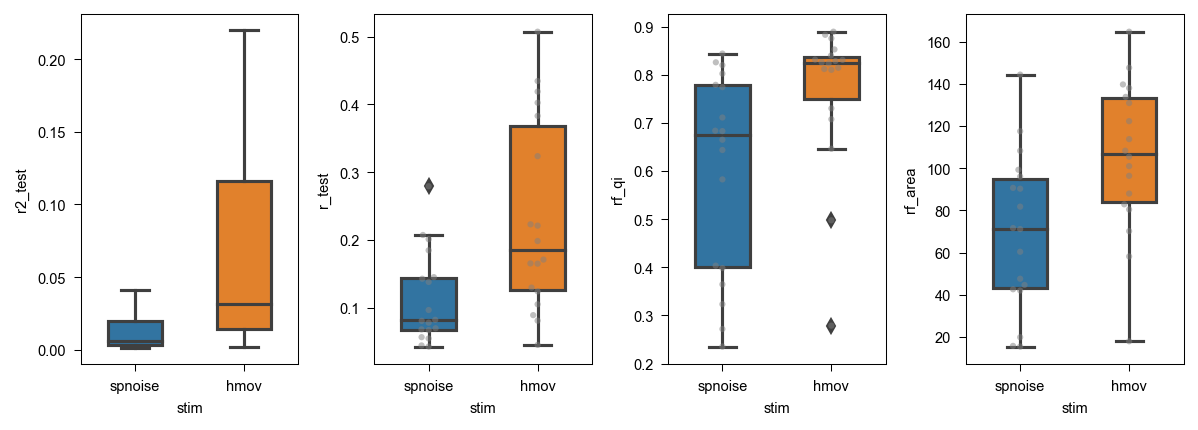

In [69]:
fig, axs = plt.subplots(nrows=1, ncols=4, figsize=cm2inch((20,7)), dpi=150, constrained_layout=True)

sns.boxplot(data=df, x='stim', y='r2_test', width=0.5, ax=axs[0])
sns.boxplot(data=df, x='stim', y='r_test', width=0.5, ax=axs[1])
sns.swarmplot(data=df, x='stim', y='r_test', color='grey', edgecolor='gray', alpha=0.5, size=3, ax=axs[1])
# sns.kdeplot(data=df, y='stim', hue='r_test', ax=axs)
sns.boxplot(data=df, x='stim', y='rf_qi', width=0.5, ax=axs[2])
sns.swarmplot(data=df, x='stim', y='rf_qi', color='grey', edgecolor='gray', alpha=0.5, size=3, ax=axs[2])
sns.boxplot(data=df, x='stim', y='rf_area', width=0.5, ax=axs[3])
sns.swarmplot(data=df, x='stim', y='rf_area', color='grey', edgecolor='gray', alpha=0.5, size=3, ax=axs[3])
# sns.boxplot(data=df, x='stim', y='mean_stim_fr', width=0.5, ax=axs[3])
# # sns.swarmplot(data=df, x='stim', y='rf_area', color='grey', edgecolor='gray', alpha=0.5, size=3, ax=axs[2])


print(df[['stim', 'r_test', 'rf_qi', 'rf_area']].groupby('stim').agg(['mean', 'std', 'count']))

### Scatter plot 

In [101]:
## Get hmov and spnoise models and reduce to best model each
# Criteria
rf_qi_crit = 0.2
r_test_crit = 0.1
r2_test_crit_sn = 0.001  # sparse noise
r2_test_crit_hm = 0.001  # hmov

## Get matched hmov and spnoise models and reduce to best model each
# Restrict to hmov models with stimulus-only and spatial resolution to match spnoise model
keys = (SplineLNP.Eval() * SplineLNPParams() & 'spl_stim LIKE "hmov"' 
        & {'spl_pshf': 'False', 'spl_opto': 'False', 'spl_run': 'False', 'spl_eye': 'False'}
        & {'spl_spat_df': 13} & 'spl_spat_scaling LIKE 0.0495'  # due to SQL float imprecision
        & f'spl_rf_qi > {rf_qi_crit}' 
#         & f'spl_r_test > {r_test_crit}'
        & f'spl_r2_test > {r2_test_crit_hm}'
       ).fetch(dj.key, as_dict=True)
df1 = get_best_model(keys, crit='spl_r_test', key_only=False, format='df')  # picks best model
print('hmov df length:', len(df1))

# Restrict to spnoise models with stimulus-only and spatial resolution to match hmov model
keys = (SplineLNP.Eval() * SplineLNPParams() & 'spl_stim LIKE "spnoise"' 
        & {'spl_pshf': 'False', 'spl_opto': 'False', 'spl_run': 'False', 'spl_eye': 'False'}
        & {'spl_spat_df': 12, 'spl_spat_scaling': 0}
        & f'spl_rf_qi > {rf_qi_crit}' 
#         & f'spl_r_test > {r_test_crit}'
        & f'spl_r2_test > {r2_test_crit_sn}'
       ).fetch(dj.key, as_dict=True)
df2 = get_best_model(keys, crit='spl_r_test', key_only=False, format='df')  # picks best model
print('spnoise df length:', len(df2))


# Merge on unit to reduce to units with both models
df = df1.merge(df2, on=['m','s','u'], how='inner')
df.columns = df.columns.str.replace(r'spl_', '')  # rmv prefixes from column names (better than lstrip)
print('merged df length:', len(df))
# df

hmov df length: 62
spnoise df length: 68
merged df length: 18


Hollywood movie vs. sparse noise models per unit 
(best model per stimulus; only stRF filter; $RF QI > 0.2$; $r^2 > 0.001$)


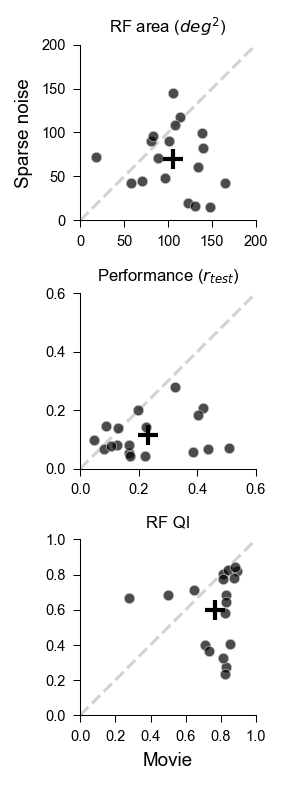

In [145]:
# Create figure
fig, axs = plt.subplots(3,1, figsize=cm2inch((5.6, 13.0)), sharex=False, sharey=False, constrained_layout=True) #dpi=250, 

# Set parameters
facecolor='k'
edgecolor='lightgrey'
alpha=0.7
markersize=25

# Scatter plots
sns.scatterplot(data=df, x='rf_area_x', y='rf_area_y', facecolor=facecolor, edgecolor=edgecolor, alpha=alpha, s=markersize, ax=axs[0])#, hue='m')
sns.scatterplot(data=df, x='r_test_x', y='r_test_y', facecolor=facecolor, edgecolor=edgecolor, alpha=alpha, s=markersize, ax=axs[1])#, hue='m')#, hue_norm=(-0.15,0.15)), hue='omi_stim', palette='RdBu', style='m_genotype',
sns.scatterplot(data=df, x='rf_qi_x', y='rf_qi_y', facecolor=facecolor, edgecolor=edgecolor, alpha=alpha, s=markersize, ax=axs[2])
# sns.scatterplot(data=df, x='rf_val_x', y='rf_val_y', ax=axs[2])#, hue='m')
# sns.scatterplot(data=df, x='r2_test_x', y='r2_test_y', ax=axs[0])#, hue='m')#, hue_norm=(-0.15,0.15)), hue='omi_stim', palette='RdBu', style='m_genotype',


# Legend
# axs[0].legend().set_visible(False)
# axs[1].legend().set_visible(False)
# axs[2].legend().set_visible(False)
# axs[3].legend().set_visible(False)

# Mean markers
axs[0].plot(df['rf_area_x'].mean(), df['rf_area_y'].mean(), 'k+', markersize=10, markeredgewidth=2)
axs[1].plot(df['r_test_x'].mean(), df['r_test_y'].mean(), 'k+', markersize=10, markeredgewidth=2)
axs[2].plot(df['rf_qi_x'].mean(), df['rf_qi_y'].mean(), 'k+', markersize=10, markeredgewidth=2)
# axs[2].plot(df['rf_val_x'].mean(), df['rf_val_y'].mean(), 'k+', markersize=10, markeredgewidth=2)
# axs[0].plot(df['r2_test_x'].mean(), df['r2_test_y'].mean(), 'k+', markersize=10, markeredgewidth=2)

# Axis titles and labels
axs[0].set_title('RF area ($deg^2$)')
axs[1].set_title('Performance ($r_{test}$)')
axs[2].set_title('RF QI')
# axs[2].set_title('$RF polarity$')
# axs[0].set_title('$r^2_{test}$')

axs[-1].set_xlabel('Movie', fontsize=9)#, ha='left')#, x=1.0)
axs[0].set_xlabel('')
axs[1].set_xlabel('')
# axs[3].set_xlabel('')

axs[0].set_ylabel('Sparse noise', fontsize=9)
axs[1].set_ylabel('')
axs[2].set_ylabel('')
# axs[3].set_ylabel('')

txt = f'Hollywood movie vs. sparse noise models per unit \n(best model per stimulus; only stRF filter; $RF QI > {rf_qi_crit}$; $r^2 > {r2_test_crit_sn}$)'
print(txt)
# fig.suptitle(txt)

############# Make x- & y-axis square, with same aspect ratio and same ticks #############
# This seems weirdly hard, and it is unclear why this solution works.
# Putting it into a function does not work

# Make aspect ratio equal (this does not auto-make the axes square (only if lims manually equalized), and ticklabels are diff)
for ax in axs: ax.set_aspect('equal', adjustable='box')

# Make axes square (same effect here as set_aspect:equal)
# for ax in axs: ax.axis('square')  # it matters where in the code this is placed!
# axs[0].axis('square')  # it matters a lot where in the code this is placed!
# axs[0].axis('equal')  # same as set_aspect, not square

# Set axis limits (this does not seem necessary after setting ticks)
# Using get_xlim() is more flexible than setting limits manually but we need ensure to encapsulate whole range of x and y
for ax in axs: 
    ax.set_xlim(np.min([*ax.get_xlim(), *ax.get_ylim()]), np.max([*ax.get_xlim(), *ax.get_ylim()]))
    ax.set_ylim(np.min([*ax.get_xlim(), *ax.get_ylim()]), np.max([*ax.get_xlim(), *ax.get_ylim()]))
# axs[0].set_ylim(np.min([*axs[0].get_xlim(), *axs[0].get_ylim()]), np.max([*axs[0].get_xlim(), *axs[0].get_ylim()]))

# Set x and y ticks
# x_ticks seems to return a different set of ticks from the one actually displayed unless explicitly set (e.g. x did not have neg values in first place)
# Unclear why this works to produce desired effect
for ax in axs:  # use xticks bc larger range for hmov
    ax.set_yticks(ax.get_xticks()[ax.get_xticks() >= 0])  # manually excluding x-ticks below 0
    ax.set_xticks(ax.get_xticks()[ax.get_xticks() >= 0])  # manually excluding x-ticks below 0
axs[1].set_yticks(axs[1].get_xticks())
axs[1].set_xticks(axs[1].get_xticks())


# Draw diagonal lines (only makes sense after everything else has been brought into same range)
for ax in axs: ax.plot([0, 1], [0, 1], color='lightgrey', linestyle='--', transform=ax.transAxes, zorder=-1)
# for ax in axs: ax.plot([0, 40], [0, 40], color='grey', linestyle='--', zorder=-1)  # explicit limits

# Despine axes
# for ax in axs: adjust_spines(ax, spines=['bottom', 'left'], spine_pos=2)  # has issues w uneven spines
sns.despine()

# Save figure
plt.savefig('./figs/hmov_vs_spnoise_population_scatter.pdf')

### Stats

In [72]:
df[['r2_test_x', 'r2_test_y', 'r_test_x', 'r_test_y', 'rf_qi_x', 'rf_qi_y', 'rf_area_x', 'rf_area_y']].describe()
# df.iloc[:, 4::].describe()

,r2_test_x,r2_test_y,r_test_x,r_test_y,rf_qi_x,rf_qi_y,rf_area_x,rf_area_y
count,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000
mean,0.063980,0.012516,0.232762,0.113337,0.765538,0.600704,105.551317,69.966472
std,0.069468,0.012171,0.141934,0.067621,0.154957,0.209662,36.008237,36.777555
min,0.002152,0.001147,0.045194,0.042839,0.278811,0.235389,17.918400,15.439700
25%,0.014380,0.003197,0.125614,0.067300,0.750282,0.399674,84.161625,43.110625
50%,0.031825,0.006080,0.184817,0.081480,0.824775,0.674043,106.910000,71.384050
75%,0.116379,0.020060,0.368344,0.144599,0.837884,0.777988,133.116750,94.714550
max,0.220024,0.041381,0.507433,0.279325,0.889586,0.844142,164.770000,144.429000


In [73]:
print('r2 test performance:', stats.wilcoxon(df['r2_test_x'], df['r2_test_y']))
print('r test performance:', stats.wilcoxon(df['r_test_x'], df['r_test_y']))
print('RF QI:', stats.wilcoxon(df['rf_qi_x'], df['rf_qi_y']))
print('RF area:', stats.wilcoxon(df['rf_area_x'], df['rf_area_y']))

r2 test performance: WilcoxonResult(statistic=13.0, pvalue=0.00067138671875)
r test performance: WilcoxonResult(statistic=18.0, pvalue=0.00193023681640625)
RF QI: WilcoxonResult(statistic=29.0, pvalue=0.01203155517578125)
RF area: WilcoxonResult(statistic=32.0, pvalue=0.0182342529296875)
